In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import scipy
import random
import itertools
import csv
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

Demographic

In [2]:
demographic = pd.read_csv('demographic.csv')

# function to recode the ethnicity column based on the given conditions
def recode_ethnicity(cell):
    if 'ASIAN' in cell:
        return 'ASIAN'
    elif 'WHITE' in cell:
        return 'WHITE'
    elif 'BLACK' in cell:
        return 'BLACK'
    elif 'HISPANIC' in cell:
        return 'HISPANIC'
    else:
        return 'OTHERS'

demographic['ethnicity'] = demographic['ethnicity'].apply(recode_ethnicity)

numerical_columns = ['age', 'bmi', 'avg_sofa_score']
categorical_columns = ['mech_vent', 'gender', 'ethnicity', 'metastatic_cancer', 'admission_type']

# select the specified features into a new DataFrame called 'demo_filtered'
demo_filtered = demographic[numerical_columns + ['mortality'] + categorical_columns + ['subject_id']]

# one-hot encoding on the categorical variables within the demo_filtered dataframe
demo_filtered_encoded = pd.get_dummies(demo_filtered, columns=categorical_columns)

demo_filtered_encoded.head()

,age,bmi,avg_sofa_score,mortality,subject_id,mech_vent_0,mech_vent_1,gender_F,gender_M,ethnicity_ASIAN,ethnicity_BLACK,ethnicity_HISPANIC,ethnicity_OTHERS,ethnicity_WHITE,metastatic_cancer_0,metastatic_cancer_1,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT
0,76.437652,NaN,5.0,0,360,0,1,1,0,0,0,0,0,1,1,0,0,1,0
1,53.510765,NaN,5.0,0,361,1,0,0,1,0,0,0,1,0,1,0,0,1,0
2,59.787646,NaN,4.0,0,367,1,0,1,0,0,0,0,0,1,1,0,0,1,0
3,55.243174,8.274705,5.0,1,61,1,0,0,1,0,0,0,0,1,1,0,0,1,0
4,41.823775,9.157622,4.0,0,68,1,0,1,0,0,1,0,0,0,1,0,0,1,0


Notes

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ioah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
notes = pd.read_csv('patient_notes.csv')

notes = notes.drop(columns=['hadm_id','chartdate','category'])

notes = notes.groupby('subject_id').agg({'text': ' '.join, 'mortality': 'first'}).reset_index()

stop_words = set(stopwords.words('english'))
for i in range(len(notes)):
  s = notes['text'][i]
  # lowercasing
  s = s.lower()
  # remove punctuation
  s = re.sub(r'[^\w\s]', '', s)
  # remove stopwords
  s = ' '.join([word for word in s.split() if word not in stop_words])
  notes['text'][i] = s
  
notes.head()

,subject_id,text,mortality
0,3,sinus rhythm pr interval increased late r wave...,0
1,21,sinus bradycardia left atrial abnormality nons...,0
2,36,2134512 802 cta chest wwo crecons noncoronary ...,0
3,38,2166829 327 pm chest portable ap clip clip num...,0
4,59,21971117 921 abdomen supine erect clip clip nu...,0


Physiological

In [5]:
ts = pd.read_csv('ts.csv')

# aggregating the data by subject_id
aggregated_data = ts.groupby('subject_id').agg('mean')

# resetting index to make subject_id a column again
aggregated_data.reset_index(inplace=True)

aggregated_data.head()

,subject_id,hadm_id,avg_heartrate,avg_sysbp,avg_diasbp,avg_meanbp,avg_resprate,avg_temperature_c,avg_spo2,aniongap,...,platelet,potassium,potassium_mv,sodium,sodium_mv,bun,wbc,wbc_mv,inr,mortality
0,3,145834.0,102.696970,107.909091,60.696970,76.848485,12.393939,37.022650,98.600000,19.75,...,267.333333,NaN,4.10,NaN,140.0,42.0,NaN,18.266667,1.633333,0.0
1,21,109451.0,67.333333,103.933333,51.866667,69.222220,16.800000,36.648148,99.666667,24.50,...,261.000000,NaN,4.90,NaN,138.5,94.0,NaN,23.500000,4.000000,0.0
2,36,165660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,...,224.000000,NaN,4.20,NaN,140.0,19.0,NaN,15.600000,NaN,0.0
3,38,185910.0,105.710526,94.210526,62.131579,72.824566,24.421053,36.527778,96.837838,16.00,...,NaN,NaN,4.20,NaN,139.0,55.0,NaN,NaN,1.700000,0.0
4,59,104130.0,64.684211,111.894737,47.421053,68.912274,16.157895,36.870370,97.111111,22.00,...,184.500000,NaN,4.55,NaN,135.5,73.0,NaN,5.450000,1.900000,0.0


In [6]:
aggregated_data['mortality'].value_counts()

0.0    7344
1.0    1917
Name: mortality, dtype: int64

Combine Data

In [7]:
# merge demo_filtered_encoded and aggregated_data
merged_data_1 = pd.merge(demo_filtered_encoded, aggregated_data, on='subject_id', how='inner')

# merge the result with notes
final_merged_data = pd.merge(merged_data_1, notes, on='subject_id', how='inner')

final_merged_data.drop(['mortality_x', 'mortality_y'], axis=1, inplace=True)

In [8]:
final_merged_data.columns

Index(['age', 'bmi', 'avg_sofa_score', 'subject_id', 'mech_vent_0',
       'mech_vent_1', 'gender_F', 'gender_M', 'ethnicity_ASIAN',
       'ethnicity_BLACK', 'ethnicity_HISPANIC', 'ethnicity_OTHERS',
       'ethnicity_WHITE', 'metastatic_cancer_0', 'metastatic_cancer_1',
       'admission_type_ELECTIVE', 'admission_type_EMERGENCY',
       'admission_type_URGENT', 'hadm_id', 'avg_heartrate', 'avg_sysbp',
       'avg_diasbp', 'avg_meanbp', 'avg_resprate', 'avg_temperature_c',
       'avg_spo2', 'aniongap', 'creatinine', 'chloride', 'chloride_mv',
       'hemoglobin', 'hemoglobin_mv', 'lactate', 'platelet', 'potassium',
       'potassium_mv', 'sodium', 'sodium_mv', 'bun', 'wbc', 'wbc_mv', 'inr',
       'text', 'mortality'],
      dtype='object')

In [9]:
# initialize the MICE imputer
mice_imputer = IterativeImputer(random_state=19437278)

data_for_imputation = final_merged_data.drop(columns=['text'])

imputed_array = mice_imputer.fit_transform(data_for_imputation)

imputed_data = pd.DataFrame(imputed_array, columns=data_for_imputation.columns)

final_imputed = imputed_data.join(final_merged_data['text'])

In [10]:
test_ids = pd.read_csv('demo_xgb.csv')

# split the data
train = final_imputed[~final_imputed['subject_id'].isin(test_ids['ID'])]
test = final_imputed[final_imputed['subject_id'].isin(test_ids['ID'])]

In [11]:
vectorizer = CountVectorizer()

# apply CountVectorizer (BoW) on the 'text' column
train_bow = vectorizer.fit_transform(train['text'])
test_bow = vectorizer.transform(test['text'])

# initialize TfidfTransformer
tfidf_transformer = TfidfTransformer()

# transform BoW features into TF-IDF features
train_tfidf = tfidf_transformer.fit_transform(train_bow)
test_tfidf = tfidf_transformer.transform(test_bow)

In [12]:
# extracting structured data (excluding 'text', 'subject_id', and 'mortality')
structured_train = train.drop(['text', 'subject_id', 'mortality'], axis=1)
structured_test = test.drop(['text', 'subject_id', 'mortality'], axis=1)

# convert structured data to sparse matrix
structured_train_sparse = scipy.sparse.csr_matrix(structured_train.values)
structured_test_sparse = scipy.sparse.csr_matrix(structured_test.values)

# concatenate TF-IDF features with the structured features
combined_train_data = hstack([structured_train_sparse, train_tfidf])
combined_test_data = hstack([structured_test_sparse, test_tfidf])

In [13]:
y_train = train['mortality']

# initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=19437278)

# apply undersampling on the combined training data
X_train_resampled, y_train_resampled = rus.fit_resample(combined_train_data, y_train)

Logistic Regression

AUC Score: 0.7224808648307426
Precision: 0.3457854406130268
Recall: 0.6278260869565218
F1-Score: 0.4459542927733169


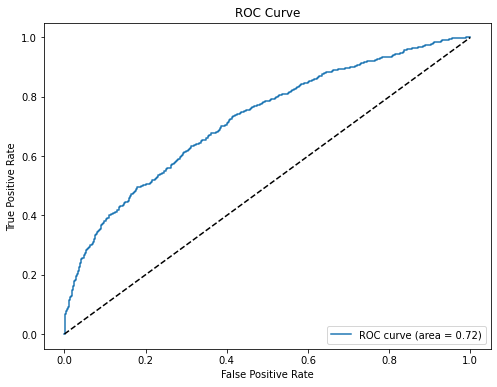

In [14]:
y_test = test['mortality']

lr = LogisticRegression(penalty='l2', C=0.7, max_iter=1000, random_state=19437278)

lr.fit(X_train_resampled, y_train_resampled)

y_pred = lr.predict(combined_test_data)
y_pred_proba = lr.predict_proba(combined_test_data)[:, 1]  

# AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

XGBoost

AUC Score: 0.8564538783239959
Precision: 0.4756637168141593
Recall: 0.7478260869565218
F1-Score: 0.581473968897904


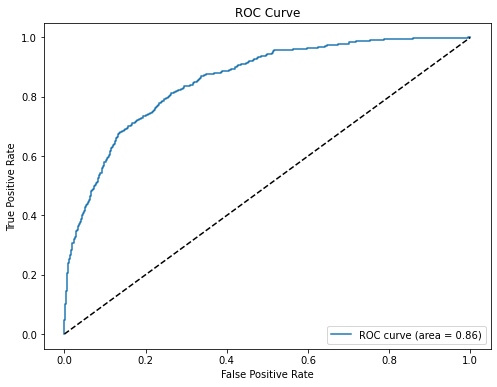

In [15]:
y_test = test['mortality']

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    colsample_bytree=0.3,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=19437278
)

xgb_clf.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_clf.predict(combined_test_data)
y_pred_proba = xgb_clf.predict_proba(combined_test_data)[:, 1] 


auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Random Forest

In [16]:
y_test = test['mortality']

rf_params = {
    'n_estimators': 300, 
    'max_features': 'sqrt', 
    'max_depth': 10, 
    'min_samples_split': 5, 
    'min_samples_leaf': 2, 
    'bootstrap': True,
    'random_state': 19437278
}

rf = RandomForestClassifier(**rf_params)

rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(combined_test_data)
y_pred_proba = rf.predict_proba(combined_test_data)[:, 1]

# AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

# precision, recall, and f1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

AUC Score: 0.787943659749073
Precision: 0.3953033268101761
Recall: 0.7026086956521739
F1-Score: 0.5059486537257357
